# Throttling handling demo

## Throttling handling approach is business case dependent
Possible scenarios:
1. discard the rejected request altogether
1. retry with active waiting until success or maximum retry number has been reached
1. put the request on a background queue that is periodically processed by background worker and continue execution

## Scenario 2: retry with active waiting

### Initializing API client and query object

In [1]:
import os
import pandas as pd
from io import BytesIO
from PIL import Image
from datetime import datetime
from throttling_retry_demo import get_connector, RequestLimitExceededError
from kentik_api.throttling.cmd import Cmd 
from kentik_api.throttling.active_wait_retry import active_wait_retry
from kentik_api.throttling.background_queue import BackgroundCmdQueue
from kentik_api.api_resources.query_api import QueryAPI
from kentik_api import (
    QueryObject,
    SQLQuery,
    QueryArrayItem,
    Query,
    Aggregate,
    AggregateFunctionType,
    FastDataType,
    MetricType,
    DimensionType,
    ImageType,
    ChartViewType,
)

api_connector = get_connector()
query_client = QueryAPI(api_connector)

agg1 = Aggregate(name="avg_bits_per_sec", column="f_sum_both_bytes", fn=AggregateFunctionType.average, raw=True)
agg2 = Aggregate(name="p95th_bits_per_sec", column="f_sum_both_bytes", fn=AggregateFunctionType.percentile, rank=95)
agg3 = Aggregate(name="max_bits_per_sec", column="f_sum_both_bytes", fn=AggregateFunctionType.max)

query = Query(
    dimension=[DimensionType.Traffic],
    cidr=32,
    cidr6=128,
    metric=MetricType.bytes,
    topx=8,
    depth=75,
    fastData=FastDataType.auto,
    outsort="avg_bits_per_sec",
    overlay_day=-7,
    show_overlay=False,
    sync_axes=False,
    viz_type=ChartViewType.stackedArea,
    lookback_seconds=3600,
    hostname_lookup=True,
    device_name=[],
    matrixBy=[],
    all_selected=True,
    filters_obj=None,
    descriptor="",
    aggregates=[agg1, agg2, agg3],
)

query_item = QueryArrayItem(query=query, bucket="Left +Y Axis", isOverlay=False)
query_object = QueryObject(queries=[query_item], imageType=ImageType.png)

## Sending chart query request (Expected result - success)

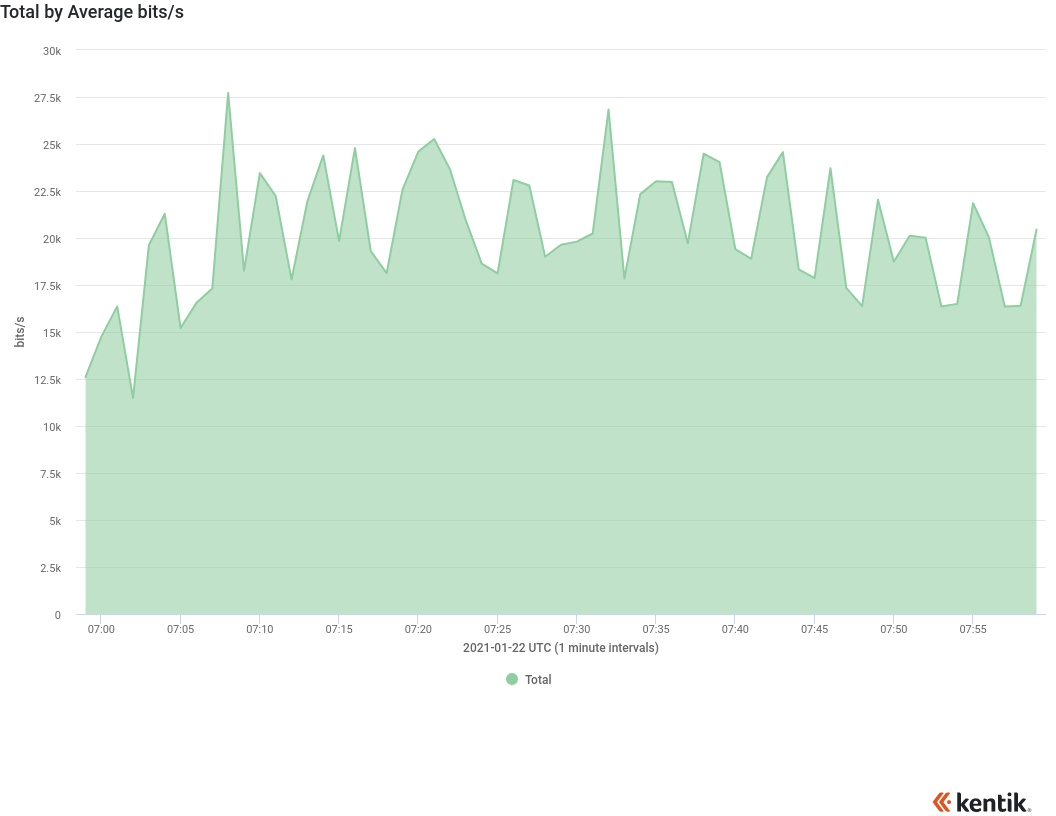

In [2]:
result = query_client.chart(query_object)
img = Image.open(BytesIO(result.get_data()))
img

## Sending another chart query request  (Expected result - request limit exceeded)

In [3]:
try:
    result = query_client.chart(query_object)
    img = Image.open(BytesIO(result.get_data()))
    img
except RequestLimitExceededError:
    print ("Query limit exceeded")

Query limit exceeded


## Retrying chart query request (Expected result - initial failures, eventual success)

execution failed with "too many requests". Retrying in 5 seconds...
execution failed with "too many requests". Retrying in 5 seconds...
execution failed with "too many requests". Retrying in 5 seconds...
execution failed with "too many requests". Retrying in 5 seconds...


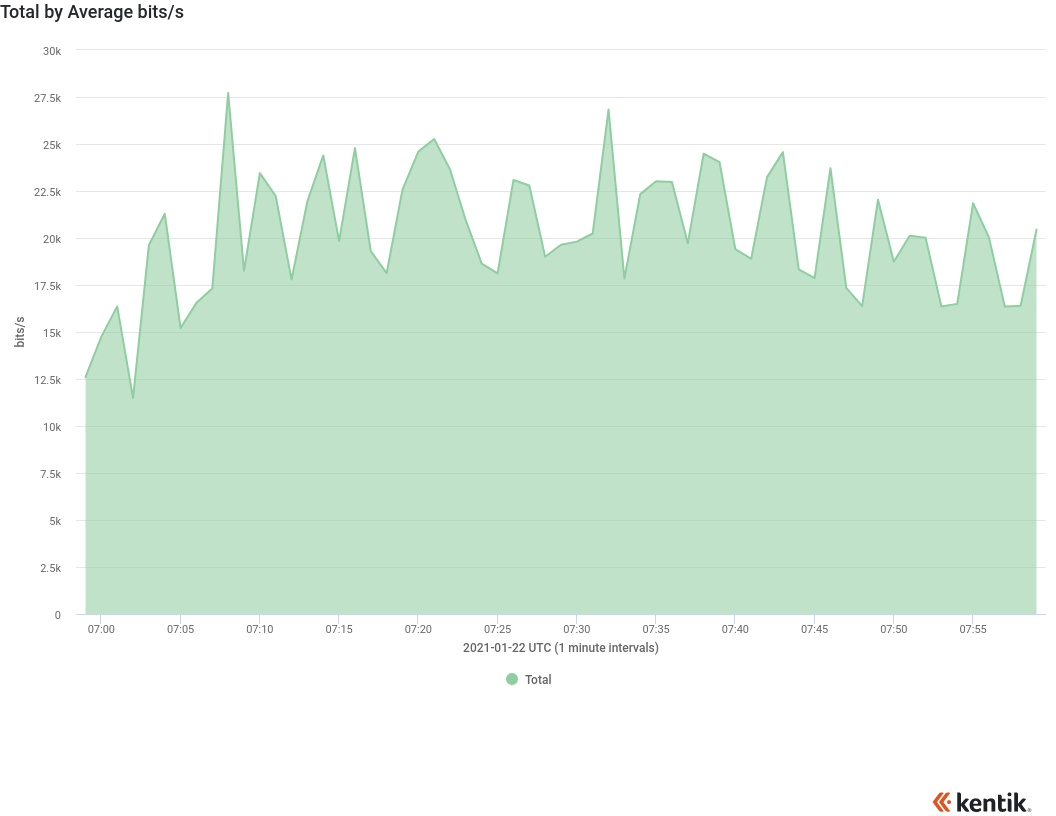

In [4]:
query_chart_cmd = Cmd(method=query_client.chart, query=query_object)
result = active_wait_retry(cmd=query_chart_cmd, num_attempts=5, retry_delay_seconds=5)
img = Image.open(BytesIO(result.get_data()))
img

## Scenario 3: background queue

In [5]:
# command execution success handler
def success(result):
    print("execution successfull. Received image type:", result.image_type)

# command execution abort handler - all attempts exhausted    
def abort(error):
    print("execution aborted: " + str(error))

# put the command on the queue
queue = BackgroundCmdQueue(retry_delay_seconds=5)
queue.put(cmd=query_chart_cmd, num_attempts=5, on_success=success, on_abort=abort)

# block foreground thread; background worker is doing it's background work
x = input()

execution failed with "too many requests". Retrying in 5 seconds...
execution failed with "too many requests". Retrying in 5 seconds...
execution failed with "too many requests". Retrying in 5 seconds...
execution failed with "too many requests". Retrying in 5 seconds...
execution successfull. Received image type: ImageType.png

